In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial import Polynomial
from scipy.optimize import curve_fit
#%matplotlib widget

In [102]:
#Properties & Constants
SB = 0.000000056704
def get_NF_SpecificHeat(T):
    return ((0.0058*T + 1.6824)*1000)

def get_NF_Density(T):
    return ((-0.672*T + 907.26))

def get_NF_Conductivity(T):
    return ((-8*(10**-5)*T + 0.1098))

Water_SpecificHeat = 4.1819*1000
def get_Water_Density(T):
    return ((-0.4179*T + 1007.8))

def get_SS_SpecficHeat(T):
    return ((0.0002*1000*T + 0.4813))

def get_SS_Conductivity(T):
    return ((0.014*T + 14.94))

In [103]:
#Geometry and Emmisvity
PP_Length = 1.2192
PP_Width = 0.3048
PP_SurfaceArea = PP_Length * PP_Width
PP_flat_thickness = 3.429/1000
PP_inflated_thickness = 1.2192/1000
PP_mass = (PP_flat_thickness+PP_inflated_thickness)* PP_SurfaceArea *7900

Heater_Length = 1.059
Heater_SurfaceArea = Heater_Length*PP_Width

HX_Emmisivty = 0.64
Water_Emmisivty = 1
VF = 1

PP_average_inflation = 1.98882/1000
PP_effective_inflation = 0.91/1000
Oil_Volume = PP_average_inflation* Heater_SurfaceArea

Heater_Voltage = 69
Heater_Resistance = 2.54
#Heater_Current = 18.55
Heater_power = Heater_Voltage**2 / Heater_Resistance
print('heater Power is (W): ', Heater_power)
print('heater Power Density is (kW/m2): ', Heater_power/Heater_SurfaceArea/1000)

heater Power is (W):  1874.4094488188975
heater Power Density is (kW/m2):  5.80702294549065


<>:70: SyntaxWarning: invalid escape sequence '\d'
<>:70: SyntaxWarning: invalid escape sequence '\d'
<>:70: SyntaxWarning: invalid escape sequence '\d'
<>:70: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Gagan Malik\AppData\Local\Temp\ipykernel_52576\1451688347.py:70: SyntaxWarning: invalid escape sequence '\d'
  temperature_data = read_temperature_data('..\data\sc-NF-pp-10_02_6W.xlsx', '..\data\sc-NF-water-10_02_6W.xlsx')
C:\Users\Gagan Malik\AppData\Local\Temp\ipykernel_52576\1451688347.py:70: SyntaxWarning: invalid escape sequence '\d'
  temperature_data = read_temperature_data('..\data\sc-NF-pp-10_02_6W.xlsx', '..\data\sc-NF-water-10_02_6W.xlsx')


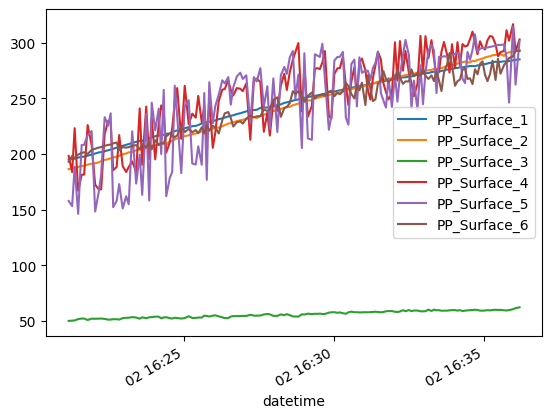

<Axes: xlabel='datetime'>

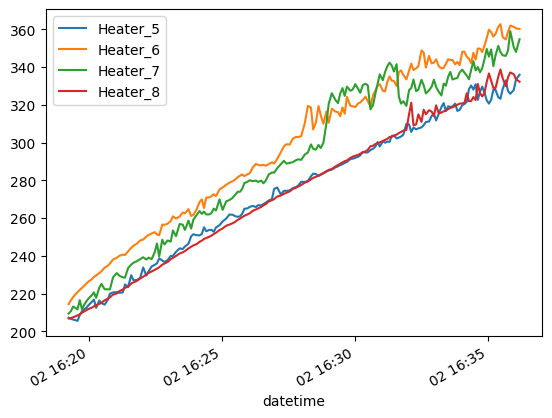

In [104]:
#Data Processing
FlowRate = 1
SetTemperature = 125
WaterVolume_gallons = 2

def read_temperature_data(file1, file2):

    # Read the first file, skip the first 4 rows, and ignore headers
    df1 = pd.read_excel(file1, skiprows=4, header=None)
    
    # Assign column names to df1
    df1_columns = ['Index', 'Date', 'Time']  # First three columns
    # Next 6 columns: PP_Surface_1 to PP_Surface_6
    df1_columns += [f'PP_Surface_{i}' for i in range(1, 7)]
    # Next 2 columns: PP_inlet and PP_outlet
    df1_columns += ['PP_inlet', 'PP_outlet']
    # Select only the necessary columns
    df1 = df1.iloc[:, :len(df1_columns)]
    df1.columns = df1_columns

    # Read the second file, skip the first 3 rows, and ignore headers
    df2 = pd.read_excel(file2, skiprows=4, header=None)

    
    # Assign column names to df2
    df2_columns = ['Index', 'Date', 'Time']  # First three columns
    # Next 3 columns: Water_1 to Water_3
    df2_columns += [f'Water_{i}' for i in range(1, 4)]
    df2_columns +=['null']
    df2_columns += [f'Heater_{i}' for i in range(5, 9)]
    # Select only the necessary columns
    df2 = df2.iloc[:, :len(df2_columns)]
    df2.columns = df2_columns

    # Combine 'Date' and 'Time' columns into a single datetime column
    df1['datetime'] = pd.to_datetime(df1['Date'].astype(str) + ' ' + df1['Time'].astype(str))
    df2['datetime'] = pd.to_datetime(df2['Date'].astype(str) + ' ' + df2['Time'].astype(str))

    df1 = df1[['datetime'] + df1_columns[3:]]  # Keep 'datetime' and temperature columns
    df2 = df2[['datetime'] + df2_columns[3:]]

    # Sort the DataFrames by datetime
    df1 = df1.sort_values('datetime').reset_index(drop=True)
    df2 = df2.sort_values('datetime').reset_index(drop=True)

    # Find the later starting time
    start_time = max(df1['datetime'].iloc[0], df2['datetime'].iloc[0])

    # Filter the DataFrames to start from the later time
    df1 = df1[df1['datetime'] >= start_time].reset_index(drop=True)
    df2 = df2[df2['datetime'] >= start_time].reset_index(drop=True)

    # Merge the DataFrames on 'datetime' within a 2-second tolerance
    merged = pd.merge_asof(
        df1,
        df2,
        on='datetime',
        direction='nearest',
        tolerance=pd.Timedelta(seconds=2),
    )

    # Drop rows where any temperature data is missing
    temperature_columns = df1.columns.tolist()[1:] + df2.columns.tolist()[1:]  # Exclude 'datetime'
    merged = merged.dropna(subset=temperature_columns)

    # Return the merged DataFrame with all temperature data
    return merged


temperature_data = read_temperature_data('..\data\sc-NF-pp-10_02_6W.xlsx', '..\data\sc-NF-water-10_02_6W.xlsx')
temperature_data[60:-90].plot(x='datetime', y=['PP_Surface_1', 'PP_Surface_2', 'PP_Surface_3', 'PP_Surface_4','PP_Surface_5', 'PP_Surface_6'])
plt.show()
temperature_data[40:-90].plot(x='datetime', y=['Heater_5', 'Heater_6', 'Heater_7', 'Heater_8'])

In [105]:

def extend_data_polynomial(x_col, y1_col, y2_col, range=5):
    # Fit a 3rd-order polynomial to the first y column
    coeffs1 = np.polyfit(x_col, y1_col, 1)
    poly1 = np.poly1d(coeffs1)
    
    # Fit a 3rd-order polynomial to the second y column
    coeffs2 = np.polyfit(x_col, y2_col, 1)
    poly2 = np.poly1d(coeffs2)
    
    # Create the new extended x array with twice the time range
    time_range = x_col.max() - x_col.min()
    extended_x = np.linspace(x_col.min(), x_col.max() + ((range/2)*time_range), num=range*len(x_col))  # Extend the time range by 2x
    
    # Calculate the corresponding y values using the two polynomials
    extended_y1 = poly1(extended_x)
    extended_y2 = poly2(extended_x)
    
    return extended_x, extended_y1, extended_y2
def exponential_plateau(x, A, k, c):
    return A * (1 - np.exp(-k * x)) + c
def extend_data_exponential(x_col, y1_col, y2_col, range=5):
    # Fit the first y column (y1) to the exponential plateau
    popt1, _ = curve_fit(exponential_plateau, x_col, y1_col, p0=[max(y1_col), 0.5, 175])
    A1, k1, c1 = popt1
    
    # Fit the second y column (y2) to the exponential plateau
    popt2, _ = curve_fit(exponential_plateau, x_col, y2_col, p0=[max(y2_col), 0.5, 175 ])
    A2, k2, c2 = popt2
    
    # Create an extended x array with twice the range
    time_range = x_col.max() - x_col.min()
    extended_x = np.linspace(x_col.min(), x_col.max() + ((range/2)*time_range), num=range * len(x_col))
    
    # Generate the corresponding y values using the fitted parameters
    extended_y1 = exponential_plateau(extended_x, A1, k1, c1)
    extended_y2 = exponential_plateau(extended_x, A2, k2, c2)
    
    return extended_x, extended_y1, extended_y2

<>:140: SyntaxWarning: invalid escape sequence '\d'
<>:140: SyntaxWarning: invalid escape sequence '\d'
<>:141: SyntaxWarning: invalid escape sequence '\d'
<>:141: SyntaxWarning: invalid escape sequence '\d'
<>:140: SyntaxWarning: invalid escape sequence '\d'
<>:140: SyntaxWarning: invalid escape sequence '\d'
<>:141: SyntaxWarning: invalid escape sequence '\d'
<>:141: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Gagan Malik\AppData\Local\Temp\ipykernel_52576\1559776536.py:140: SyntaxWarning: invalid escape sequence '\d'
  files = {   '200C': ('..\data\sc-NF-pp-10_02_6W.xlsx', '..\data\sc-NF-water-10_02_6W.xlsx'),
C:\Users\Gagan Malik\AppData\Local\Temp\ipykernel_52576\1559776536.py:140: SyntaxWarning: invalid escape sequence '\d'
  files = {   '200C': ('..\data\sc-NF-pp-10_02_6W.xlsx', '..\data\sc-NF-water-10_02_6W.xlsx'),
C:\Users\Gagan Malik\AppData\Local\Temp\ipykernel_52576\1559776536.py:141: SyntaxWarning: invalid escape sequence '\d'
  '125C': ('..\data\sc-NF-pp-9_25_125

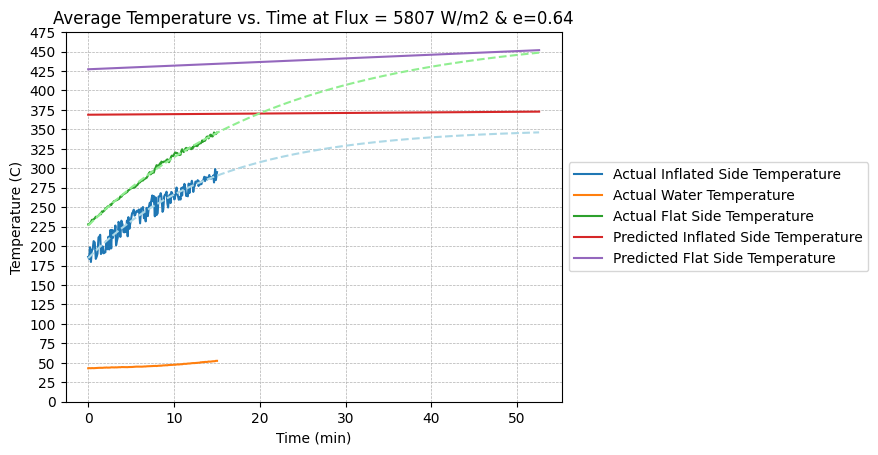

C:\Users\Gagan Malik\AppData\Local\Temp\ipykernel_52576\1559776536.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


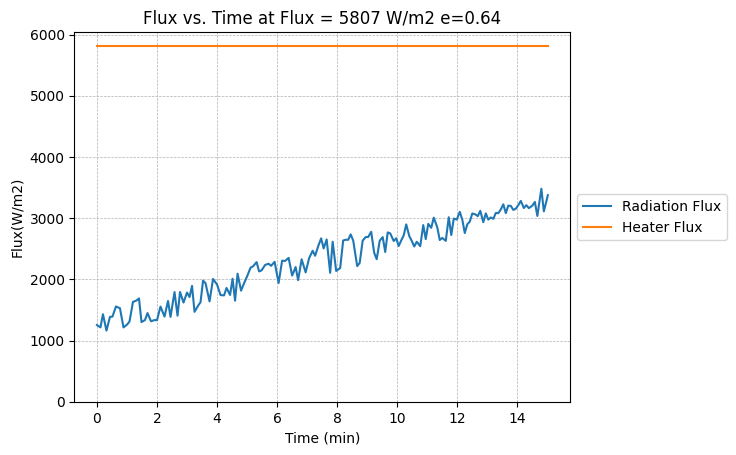

Applied Flux is:  5807.02294549065
Radiative Flux is:  3480.6995301578795
Radiative performance:  59.93948298173611 %
Experiment conductivity (W/mK):  0.11886555573074492


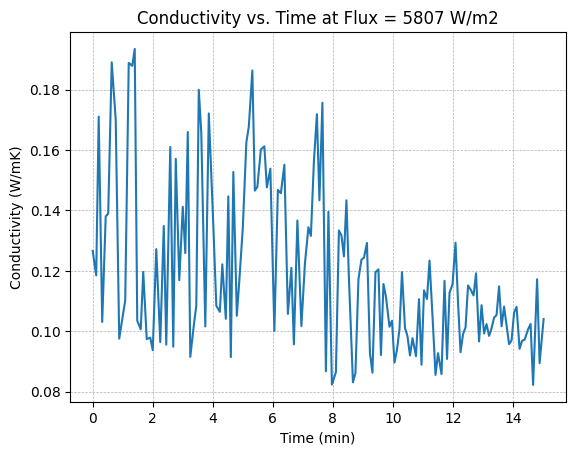

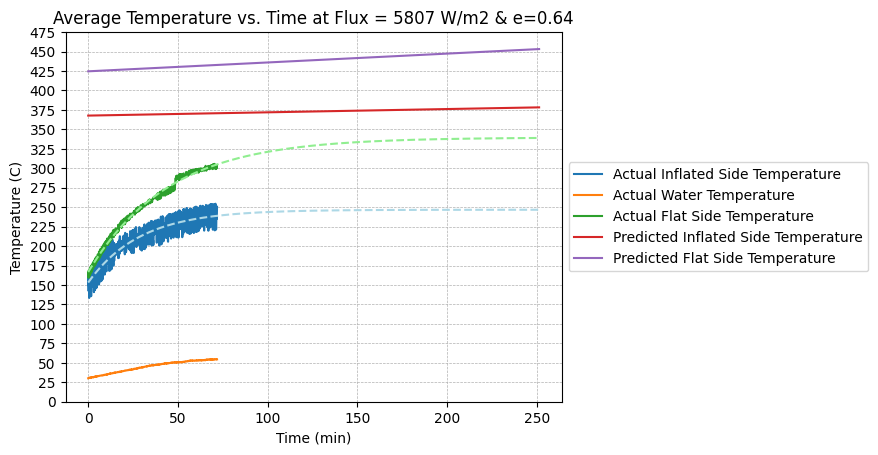

C:\Users\Gagan Malik\AppData\Local\Temp\ipykernel_52576\1559776536.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


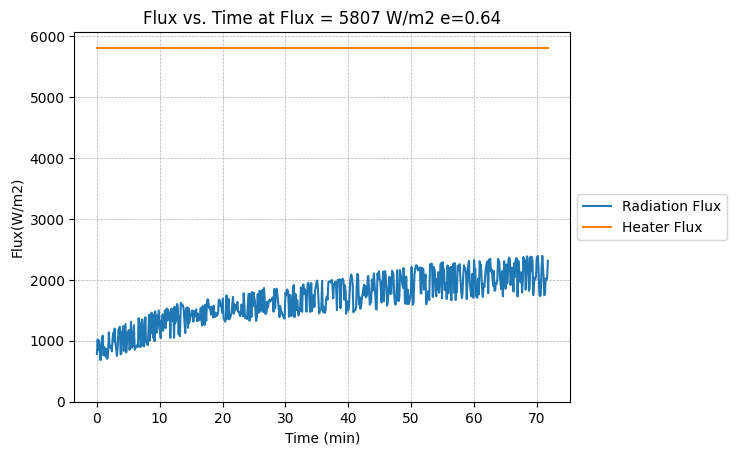

Applied Flux is:  5807.02294549065
Radiative Flux is:  2393.4377101036225
Radiative performance:  41.21626059635614 %
Experiment conductivity (W/mK):  0.18791742811660658


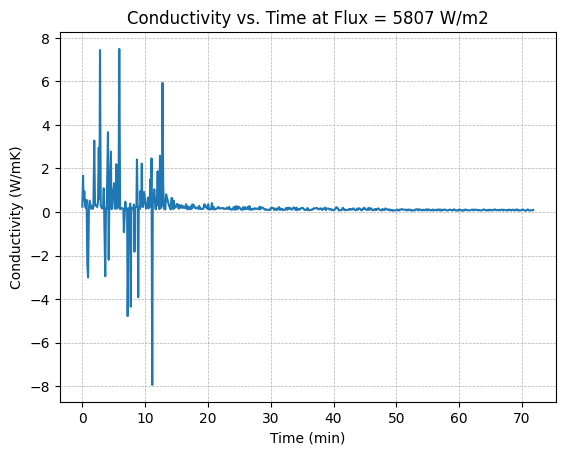

In [106]:
#Analysis with flux heater
# Calculate Average_PP_Temp
def analyze_flux(temperature_data, set_temperature):

     # Calculate elapsed time in minutes starting from 0
    temperature_data['Time_min'] = (
        temperature_data['datetime'] - temperature_data['datetime'].iloc[0]
    ).dt.total_seconds() / 60

    
    pp_temp_columns = [f'PP_Surface_{i}' for i in [1, 2,4,5,6]] #Never include TC3 because it is broken
    temperature_data['Average_PP_Temp'] = temperature_data[pp_temp_columns].mean(axis=1)

    # Calculate Average_Water_Temp
    water_temp_columns = [f'Water_{i}' for i in range(2, 4)]
    temperature_data['Average_Water_Temp'] = temperature_data[water_temp_columns].mean(axis=1)
    
    #Calcualture Average Heater_Temp
    heater_temp_columns = [f'Heater_{i}' for i in range(5, 9)]
    temperature_data['Average_Heater_Temp'] = temperature_data[heater_temp_columns].mean(axis=1)

    #Calculate Heater_Flux
    temperature_data['Heater_Flux'] = Heater_power/Heater_SurfaceArea

    #Calculate Average oil temperature
    oil_temp_columns = ['Average_PP_Temp', 'Average_Heater_Temp']
    temperature_data['Average_Oil_Temp'] = temperature_data[oil_temp_columns].mean(axis=1)
    

    #Calculate Average oil conductivity
    temperature_data['oil_conductivity'] = temperature_data['Average_Oil_Temp'].apply(get_NF_Conductivity)
    temperature_data['oil_specificHeat'] = temperature_data['Average_Oil_Temp'].apply(get_NF_SpecificHeat)
    temperature_data['SS_flat_conductivity'] = temperature_data['Average_Heater_Temp'].apply(get_SS_Conductivity)
    temperature_data['SS_inflated_conductivity'] = temperature_data['Average_PP_Temp'].apply(get_SS_Conductivity)
    temperature_data['oil_density'] = temperature_data['Average_Oil_Temp'].apply(get_NF_Density)
    temperature_data['experimental conductivity'] = temperature_data['Heater_Flux'] *PP_effective_inflation/(temperature_data['Average_Heater_Temp'] - temperature_data['Average_PP_Temp'])

    #Calculate expected temperatures
    temperature_data['Inflated_outside_temp'] = (((temperature_data['Heater_Flux']/SB/HX_Emmisivty)+(temperature_data['Average_Water_Temp']+273.15)**4)**0.25) - 273.15
    temperature_data['Inflated_inside_temp'] = (temperature_data['Heater_Flux'] * PP_inflated_thickness/temperature_data['SS_inflated_conductivity']) + temperature_data['Inflated_outside_temp']
    temperature_data['Flat_inside_temp'] = (temperature_data['Heater_Flux'] * PP_effective_inflation/temperature_data['oil_conductivity']) + temperature_data['Inflated_inside_temp']
    temperature_data['Flat_outside_temp'] = (temperature_data['Heater_Flux'] * PP_flat_thickness/temperature_data['SS_flat_conductivity']) + temperature_data['Flat_inside_temp']                                                                                                                                                                     


    # Calculate Radiation_Flux
    temperature_data['Radiation_Flux'] = SB * VF * HX_Emmisivty*(
        (temperature_data['Average_PP_Temp'] + 273.15)**4 - (temperature_data['Average_Water_Temp'] + 273.15)**4
    )


    Water_indexLength = 75
    Oil_indexLength  = 12

    # Calculate Oil_Calorimetry_Flux
    temperature_data['Oil_Flux'] = 0.0
    temperature_data.loc[Oil_indexLength:, 'Oil_Flux'] = (
        temperature_data.loc[Oil_indexLength:, 'oil_specificHeat']* Oil_Volume/Heater_SurfaceArea/(Oil_indexLength*5) * temperature_data.loc[Oil_indexLength:, 'oil_density']*
            (temperature_data['Average_Oil_Temp'].iloc[Oil_indexLength:] -
            temperature_data['Average_Oil_Temp'].shift(Oil_indexLength).iloc[Oil_indexLength:])
        )

    #Calcualture Steel_Calorimetry_Flux
    temperature_data['Steel_Flux'] = 0.0
    temperature_data.loc[Oil_indexLength:, 'Steel_Flux'] = (
        400 * PP_mass/Heater_SurfaceArea / (Oil_indexLength*5) *
            (temperature_data['Average_Oil_Temp'].iloc[Oil_indexLength:] -
            temperature_data['Average_Oil_Temp'].shift(Oil_indexLength).iloc[Oil_indexLength:])
        )
    

    # Initialize Water_Flux column with zeros
    temperature_data['Water_Flux'] = 0.0
    Water_Density = get_Water_Density(21)
    WaterMass = WaterVolume_gallons*0.00378541 * Water_Density

    # Calculate Water_Calorimetry_Flux where applicable
    temperature_data.loc[Water_indexLength:, 'Water_Flux'] = (
        Water_SpecificHeat * WaterMass/(Water_indexLength*5)/PP_SurfaceArea * (
            temperature_data['Average_Water_Temp'].iloc[Water_indexLength:] -
            temperature_data['Average_Water_Temp'].shift(Water_indexLength).iloc[Water_indexLength:]
        )
    )
    
    #Extend Data
    extended_time, extended_actual_inflated, extended_actual_flat = extend_data_exponential(temperature_data['Time_min'], temperature_data['Average_PP_Temp'], temperature_data['Average_Heater_Temp'])
    extended_time, extended_predicted_inflated, extended_predicted_flat = extend_data_polynomial(temperature_data['Time_min'], temperature_data['Inflated_outside_temp'], temperature_data['Flat_outside_temp'])



    plt.plot(temperature_data['Time_min'], temperature_data['Average_PP_Temp'], label='Actual Inflated Side Temperature')
    plt.plot(temperature_data['Time_min'], temperature_data['Average_Water_Temp'], label='Actual Water Temperature')
    plt.plot(temperature_data['Time_min'], temperature_data['Average_Heater_Temp'], label='Actual Flat Side Temperature')
    # plt.plot(temperature_data['Time_min'], temperature_data['Inflated_outside_temp'], color='#FFA07A', linestyle = '--',)
    # plt.plot(temperature_data['Time_min'], temperature_data['Flat_outside_temp'], color='#E6E6FA', linestyle = '--',)
    plt.plot(extended_time, extended_predicted_inflated, label='Predicted Inflated Side Temperature')
    plt.plot(extended_time, extended_predicted_flat, label='Predicted Flat Side Temperature')
    plt.plot(extended_time, extended_actual_inflated, color = 'lightblue', linestyle='--')
    plt.plot(extended_time, extended_actual_flat, color = 'lightgreen', linestyle='--')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.yticks(range(0, 500, 25))
    plt.ylabel('Temperature (C)')
    plt.xlabel('Time (min)')
    plt.title('Average Temperature vs. Time at Flux = ' + f"{Heater_power/Heater_SurfaceArea:.0f}" + ' W/m2 & e=' + f"{HX_Emmisivty:.2f}")
    plt.show()


    #-------PLOT FLUXES --------#
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.plot(temperature_data['Time_min'], temperature_data['Radiation_Flux'], label='Radiation Flux')
    plt.plot(temperature_data['Time_min'], temperature_data['Heater_Flux'], label='Heater Flux')
    #plt.plot(temperature_data['Time_min'], temperature_data['Oil_Flux'], label='Oil Calorimetry Flux')
    #plt.plot(temperature_data['Time_min'], temperature_data['Steel_Flux'], label='Steel Calorimetry Flux')
    #plt.plot(temperature_data['Time_min'], temperature_data['Water_Flux'], label='Water Calorimetry Flux')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim(ymin=0)
    plt.ylabel('Flux(W/m2)')
    plt.xlabel('Time (min)')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.title('Flux vs. Time at Flux = ' + f"{Heater_power/Heater_SurfaceArea:.0f}" + ' W/m2 e=' + f"{HX_Emmisivty:.2f}")
    #plt.gca().yaxis.set_major_locator(MultipleLocator(5))
    plt.show()


    print('Applied Flux is: ', temperature_data['Heater_Flux'].max())
    print('Radiative Flux is: ', temperature_data['Radiation_Flux'].max())
    print('Radiative performance: ', (temperature_data['Radiation_Flux'].max()/temperature_data['Heater_Flux'].max())*100, '%' )
    print('Experiment conductivity (W/mK): ', temperature_data['experimental conductivity'].mean())

    plt.plot(temperature_data['Time_min'], temperature_data['experimental conductivity'])
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylabel('Conductivity (W/mK)')
    plt.xlabel('Time (min)')
    plt.title('Conductivity vs. Time at Flux = ' + f"{Heater_power/Heater_SurfaceArea:.0f}" + ' W/m2' )
    plt.show()


    
files = {   '200C': ('..\data\sc-NF-pp-10_02_6W.xlsx', '..\data\sc-NF-water-10_02_6W.xlsx'),
            '125C': ('..\data\sc-NF-pp-9_25_125C.xlsx', '..\data\sc-NF-water-9_25_125C.xlsx'),
            #'125C': ('.\data\sc-NF-pp-9_20_125C.xlsx', '.\data\sc-NF-water-9_20_125C.xlsx'),
            #'25C': ('.\data\sc-NF-pp-9_20_125C.xlsx', '.\data\sc-NF-water-9_20_125C.xlsx')

}
for t in files:
    temperature_data = read_temperature_data(files[t][0], files[t][1])
    temperature_data = temperature_data[60:-90]
    analyze_flux(temperature_data, t)



In [107]:
#Analysis with flowing HTF
# Calculate Average_PP_Temp
def analyze_flux(temperature_data, set_temperature):
    pp_temp_columns = [f'PP_Surface_{i}' for i in range(1, 7)]
    temperature_data['Average_PP_Temp'] = temperature_data[pp_temp_columns].mean(axis=1)
    # Calculate Average_Water_Temp
    water_temp_columns = [f'Water_{i}' for i in range(1, 4)]
    temperature_data['Average_Water_Temp'] = temperature_data[water_temp_columns].mean(axis=1)

    

    Water_indexLength = 75

    NF_Density = get_NF_Density(SetTemperature)
    NF_SpecificHeat = get_NF_SpecificHeat(SetTemperature)

    Corrected_FlowRate = ((0.876/(NF_Density/997))**0.5)*FlowRate
    NF_MassFlow = (Corrected_FlowRate*0.00378541)/60 * NF_Density

    Water_Density = get_Water_Density(21)
    WaterMass = WaterVolume_gallons*0.00378541 * Water_Density

    # Calculate Radiation_Flux
    temperature_data['Radiation_Flux'] = SB * VF * HX_Emmisivty*(
        (temperature_data['Average_PP_Temp'] + 273.15)**4 - (temperature_data['Average_Water_Temp'] + 273.15)**4
    )

    # Calculate Oil_Flux
    temperature_data['Oil_Flux'] = NF_SpecificHeat * NF_MassFlow * (
        temperature_data['PP_inlet'] - temperature_data['PP_outlet']
    )

    # Initialize Water_Flux column with zeros
    temperature_data['Water_Flux'] = 0.0

    # Calculate Water_Flux where applicable
    temperature_data.loc[Water_indexLength:, 'Water_Flux'] = (
        Water_SpecificHeat * WaterMass/(Water_indexLength*5)/PP_SurfaceArea * (
            temperature_data['Average_Water_Temp'].iloc[Water_indexLength:] -
            temperature_data['Average_Water_Temp'].shift(Water_indexLength).iloc[Water_indexLength:]
        )
    )

    # Calculate elapsed time in minutes starting from 0
    temperature_data['Time_min'] = (
        temperature_data['datetime'] - temperature_data['datetime'].iloc[0]
    ).dt.total_seconds() / 60


    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # Plot each flux against Time_min
    plt.plot(temperature_data['Time_min'], temperature_data['Radiation_Flux'], label='Expected Radiation Flux')
    plt.plot(temperature_data['Time_min'], temperature_data['Oil_Flux'], label='Oil Calorimetry Flux')
    plt.plot(temperature_data['Time_min'], temperature_data['Water_Flux'], label='Water Calorimetry Flux')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Flux(W/m2)')
    plt.xlabel('Time (min)')

    xmin = 30
    xmax = 60
    plt.xlim(xmin=xmin, xmax=xmax)
    start_index = int(xmin*60/5)
    end_index = int(xmax*60/5)
    ymax = temperature_data.iloc[start_index:][ 'Oil_Flux'].max()*1.5
    yavearge = temperature_data.iloc[start_index:end_index][['Radiation_Flux', 'Oil_Flux', 'Water_Flux']].mean()
    print(yavearge)

    plt.ylim(ymin=0, ymax=1500)

    

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.title('Flux vs. Time at T=' + set_temperature + ' (e=0.5)')
    #plt.gca().yaxis.set_major_locator(MultipleLocator(5))
    plt.show()

    plt.plot(temperature_data['Time_min'], temperature_data['Average_PP_Temp'], label='Pillow Plate Temperature')
    plt.plot(temperature_data['Time_min'], temperature_data['Average_Water_Temp'], label='Water Temperature')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.title('Temperature vs. Time at T = ' + t)
    plt.show()



files = {
    '75C': ('Data/sc-NF-pp-9_12_75C.xlsx', './Data/sc-NF-water-9_12_75C.xlsx'),
    '125C': ('Data/sc-NF-pp-9_12_125C.xlsx', './Data/sc-NF-water-9_12_125C.xlsx'),
    '175C': ('Data/sc-NF-pp-9_13_175C.xlsx', './Data/sc-NF-water-9_13_175C.xlsx'),
}
for t in files:
    temperature_data = read_temperature_data(files[t][0], files[t][1])
    analyze_flux(temperature_data, t)



FileNotFoundError: [Errno 2] No such file or directory: 'Data/sc-NF-pp-9_12_75C.xlsx'